In [ ]:
import time
import numpy as np
import math
import pandas as pd
import time
import scipy
from scipy.sparse import random
from matplotlib import pyplot as plt

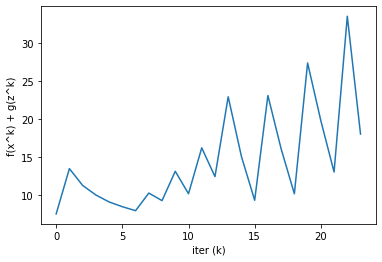

,r norm,eps pri,s norm,eps dual,objective
0,3.199172,0.023469,2.292100,0.032539,7.472479
1,3.694947,0.033683,2.647569,0.047975,13.456142
2,3.079742,0.033076,1.719095,0.055320,11.234332
3,1.779977,0.024518,0.517197,0.064801,9.973737
4,1.497510,0.023403,0.127309,0.076269,9.053532
...,...,...,...,...,...
995,6.405968,0.094602,2.112884,0.195993,34.218120
996,4.076520,0.073734,1.467882,0.201174,23.226161
997,7.317748,0.064725,8.684998,0.203814,17.540983
998,6.418239,0.117233,4.013540,0.178753,36.477757


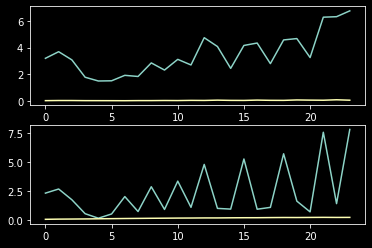

In [ ]:
class History:
    objval = []
    r_norm = []
    s_norm = []
    eps_pri = []
    eps_dual = []

def matrixMax(matrix,kappa):
    size = matrix.shape
    temp = np.zeros((size[0],size[1]))
    maxPos = np.argwhere(matrix-kappa == np.max(matrix-kappa))
    row = maxPos[0][0]
    col = maxPos[0][1]
    temp[row][col] = np.max(matrix-kappa)
    return temp

def matMul(a,b):
    p = a.shape[0]
    n = a.shape[1]
    q = b.shape[1]
    c = np.zeros(([p,q]))
    for j in range(0,n):
        for i in range(0,p):
            for k in range(0,q):
                c[i][k] += a.item((i,j)) * b.item((j,k))
    return c

def shrinkage(a, kappa):
    y = matrixMax(a-kappa, kappa) - matrixMax(-a-kappa, kappa)
    return y

def objective(x):
    obj = np.linalg.norm(x,1)
    return obj


shape = 0
start = 0
tic, toc = 0,0 

def basis_pursuit(A, b, rho, alpha):
    history = History()
    start = time.time()
    m = A.shape[0]
    n = A.shape[1]
    x = np.zeros(shape = (n,1))

    #Lagrange multipliers
    z = np.zeros(shape = (n,1)) 
    u = np.zeros(shape = (n,1))

    QUIET = 0;
    MAX_ITER = 1000;
    ABSTOL = 1e-4;
    RELTOL = 1e-2;
    if (not QUIET):
        dataDict = dict.fromkeys(['iter','r norm','eps pri','s norm','eps dual', 'objective'])
        for i in dataDict:
            dataDict[i] = []
        # print('iter     ','r norm       ', 'eps pri     ', 's norm      ', 'eps dual        ', 'objective       ');

        #projection on to Ax=b
        AAt = matMul(A,A.transpose())
        tempMult = matMul(np.linalg.inv(AAt),A)
        tempDiv = matMul(np.linalg.inv(AAt),b)
        P = np.identity(n) - matMul(A.transpose() ,tempMult )

        q = matMul(A.transpose() , tempDiv)

        for k in range (0, MAX_ITER):
            x = np.dot(P, (z-u)) + q #x-updation step
            zold = z
            x_hat = alpha*x + (1-alpha)*zold #gradf
            try:
                z = shrinkage(x_hat + u, 1/rho)
            except:
                print("Error",k)
            u += (x_hat - z)

            #termination checks

            history.objval.insert(k,objective(x))

            history.r_norm.insert(k,np.linalg.norm(x-z))
            history.s_norm.insert(k,np.linalg.norm((-1*rho)*(z-zold)))

            history.eps_pri.insert(k, math.sqrt(n)*ABSTOL + RELTOL* max(np.linalg.norm(x), np.linalg.norm(-1*z) ))
            history.eps_dual.insert(k, math.sqrt(n)*ABSTOL + RELTOL*np.linalg.norm(rho*u))


            if (not QUIET):

                dataDict.get('iter').append(k)
                dataDict.get('r norm').append(history.r_norm[k])
                dataDict.get('eps pri').append(history.eps_pri[k])
                dataDict.get('s norm').append(history.s_norm[k])
                dataDict.get('eps dual').append(history.eps_dual[k])
                dataDict.get('objective').append(history.objval[k])

                # print(k,'\t\t\t',history.r_norm[k-1],'\t\t\t',history.eps_pri[k-1], '\t\t\t',history.s_norm[k-1], '\t\t\t',history.eps_dual[k-1], '\t\t\t',history.objval[k-1]);       

            if (history.r_norm[k] < history.eps_pri[k] and history.s_norm[k] < history.eps_dual[k]):
                break   
        if (not QUIET):
            toc =  time.perf_counter()
    retList = list((z, history,dataDict))
    return retList


m = 10
n = 30

np.random.seed(7)

A = np.random.rand(m,n)

x = scipy.sparse.random(n,1, 0.5)

b =  A*x

rho = 1

alpha = 1

xtrue = x

retList =  basis_pursuit(A,b,rho,alpha)

histRet = retList[1]



k_list = list(range(0,len(histRet.objval)))



plt.plot(k_list[:24],histRet.objval[:24])
plt.style.use(['dark_background'])
plt.xlabel("iter (k)")
plt.ylabel("f(x^k) + g(z^k)")
plt.show()


subplotMax1 = []

for i in range(0, len(histRet.r_norm)):
    subplotMax1.append(max(10**-8,histRet.r_norm[i]))


subplotMax2 = []

for i in range(0, len(histRet.s_norm)):
    subplotMax2.append(max(10**-8,histRet.s_norm[i]))


fig, axs = plt.subplots(2)

axs[0].plot(k_list[:24],subplotMax1[:24], label = "Line 1")
axs[0].plot(k_list[:24],histRet.eps_pri[:24],label = "Line 2")

axs[1].plot(k_list[:24],subplotMax2[:24], label = "Line 1")
axs[1].plot(k_list[:24],histRet.eps_dual[:24],label = "Line 2")

df = pd.DataFrame(retList[2])
df.iloc[:,1:]


